# Анализ и разработка стратегии взаимодействия с клиентами фитнес-клуба

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Поскольку распространённая проблема фитнес-клубов и других сервисов — отток клиентов, необходимо провести анализ и подготовить план действий по удержанию клиентов.
В ходе проектаследует:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

   1) выделить целевые группы клиентов;
    
   2) предложить меры по снижению оттока;
   
   3) определить другие особенности взаимодействия с клиентами.
   
**Описание таблицы gym_churn**
1. Данные клиента за предыдущий до проверки факта оттока месяц::
   - gender — пол;
   - Near_Location — проживание или работа в районе, где находится фитнес-центр;
   - Partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
   - Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
   - Phone — наличие контактного телефона;
   - Age — возраст;
   - Lifetime — время с момента первого обращения в фитнес-центр (в месяцах).
   
2. Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
   - Contract_period — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
   - Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах);
   - Group_visits — факт посещения групповых занятий;
   - Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента;
   - Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц;
   - Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
   - Churn — факт оттока в текущем месяце.   



## Общая информация

Импортируем библиотеки.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
!pip install termcolor
from termcolor import colored
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
import optuna
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

Загрузим данные.

In [2]:
try:
    df = pd.read_csv('/datasets/gym_churn.csv')
except:
    df = pd.read_csv('gym_churn.csv')

Для получения общей информации о датафреймах напишем следующую функцию:

In [3]:
def get_general_info(df):
    
    print(colored('Выведем случайные 5 строк датафрейма:', attrs=['bold']))
    display(df.sample(5))
    print('\n')
    print(colored('Общая информация по датафрейму:\n', attrs=['bold']))
    df.info()
    print('\n')
    print(colored('Основные статистические характеристики данных по числовым признакам:', attrs=['bold']))
    display(df.describe())
    print('\n')
    print(colored('Количество пропущенных значений в датафрейме:', attrs=['bold']))
    display(df.isna().mean())
    print('\n')
    print(colored('Количество дубликатов в датафрейме: {}'.format(df.duplicated().sum()), attrs=['bold']))

Посмотрим общую информацию о клиентах фитнес-клуба.

In [4]:
get_general_info(df)

Выведем случайные 5 строк датафрейма:


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
2010,0,1,0,0,1,1,0,30,25.352111,1.0,6,1.789535,0.845413,1
2929,1,1,0,0,1,12,1,29,132.577448,12.0,19,1.108065,1.248685,0
1752,1,1,1,1,1,6,0,32,48.137816,6.0,8,0.799758,0.728868,0
2077,1,0,1,0,1,1,0,30,178.782326,1.0,4,2.178742,2.125643,0
1698,0,0,1,0,1,1,0,26,62.024658,1.0,1,2.513596,2.299249,1




Общая информация по датафрейму:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_t

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000




Количество пропущенных значений в датафрейме:


gender                               0.0
Near_Location                        0.0
Partner                              0.0
Promo_friends                        0.0
Phone                                0.0
Contract_period                      0.0
Group_visits                         0.0
Age                                  0.0
Avg_additional_charges_total         0.0
Month_to_end_contract                0.0
Lifetime                             0.0
Avg_class_frequency_total            0.0
Avg_class_frequency_current_month    0.0
Churn                                0.0
dtype: float64



Количество дубликатов в датафрейме: 0


**Вывод**

Датасет **gym_churn** содержит информацию о клиентах фитнес-клуба. 
- Общая длина датафрейма равна 4000 строкам, количество столбцов - 14. Пропусков в данных и дубликатов не обнаружено.
- Столбцы содержат данные числовых типов: 10 признаков имеют целочисленный тип и 4 признака — числа с плавающей точкой.
- Соотношение женщин и мужчин в датасете примерно одинаковое;
- Большинство посетителей проживают или работают в том же районе, где расположен фитнес-центр;
- Половина клиентов являются сотрудниками компаний-партнёров клуба;
- Меньшая часть посетителей пришли в рамках акции «приведи друга»;
- У 90% клиентов указан номер телефона;
- Есть 3 вида абонементов: на 1, 6 и 12 месяцев. Большинство посетителей предпочитают прибретать краткосрочные месячные программы;
- 40% клиентов посещают групповые занятия;
- Средний возраст посетителей клуба - 29 лет, небольшое стандартное отклонение говорит о незначительной вариабельности данных;
- Средняя суммарная выручка от других услуг фитнес-центра равна 147 у.е.;
- Время с момента первого обращения в фитнес-центр сильно меняется от клиента к клиенту;
- В среднем клиенты посещают клуб 1-2 раза в неделю;
- 30% клиентов перестают пользоваться услугами финтес-центра.

## Предобработка данных

### Приведение данных к нижнему регистру

In [5]:
def lower_case(dataframes = []):
    
    for df in dataframes:
        
        df.columns= df.columns.str.lower() # приведем названия столбцов к нижнему ригистру
        
        for column in df.columns:

            if df[column].dtypes == 'object':

                df[column] = df[column].str.lower() # приведем содержимое столбцов к нижнему регистру
                

lower_case(dataframes = [df])

## Исследовательский анализ данных

1. Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [6]:
df.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


2. Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

Напишем функцию вывода столбчатых гистограмм для бинарных признаков.

In [7]:
def binary_distribution(df, titles, suptitle, hue_col, legend_title, labels_title, remove=True):
    
    binary_features = []
    for col in df.columns:
        if len(df[col].value_counts()) == 2:
            binary_features.append(col)
    if remove:
        binary_features.remove('churn')

    plt.figure(figsize=(18, 20))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle(suptitle, fontsize=18, y=0.95)

    ncols = 2
    nrows = len(binary_features) // ncols + (len(binary_features) % ncols > 0)

    for i, parameter in enumerate(binary_features):

        ax = plt.subplot(nrows, ncols, i + 1)
        sns.countplot(data=df, x=parameter, hue=hue_col, ax=ax, palette='viridis', edgecolor='black')
        plt.setp(ax.patches, linewidth=1)
        ax.set_title(titles[i], y=1.05, fontsize=14)
        ax.set_ylabel('Частота', fontsize=12)
        plt.legend(title=legend_title, loc='upper right', labels=labels_title)
        plt.setp(ax.get_legend().get_texts(), fontsize='10') 
        plt.setp(ax.get_legend().get_title(), fontsize='12')
        ax.set_xlabel("")

        for p in ax.patches:
            ax.annotate(np.round(p.get_height(),decimals=2),(p.get_x()+p.get_width()/2., p.get_height()),
                    ha='center',va='center',xytext=(0, 4),textcoords='offset points')
    plt.show()


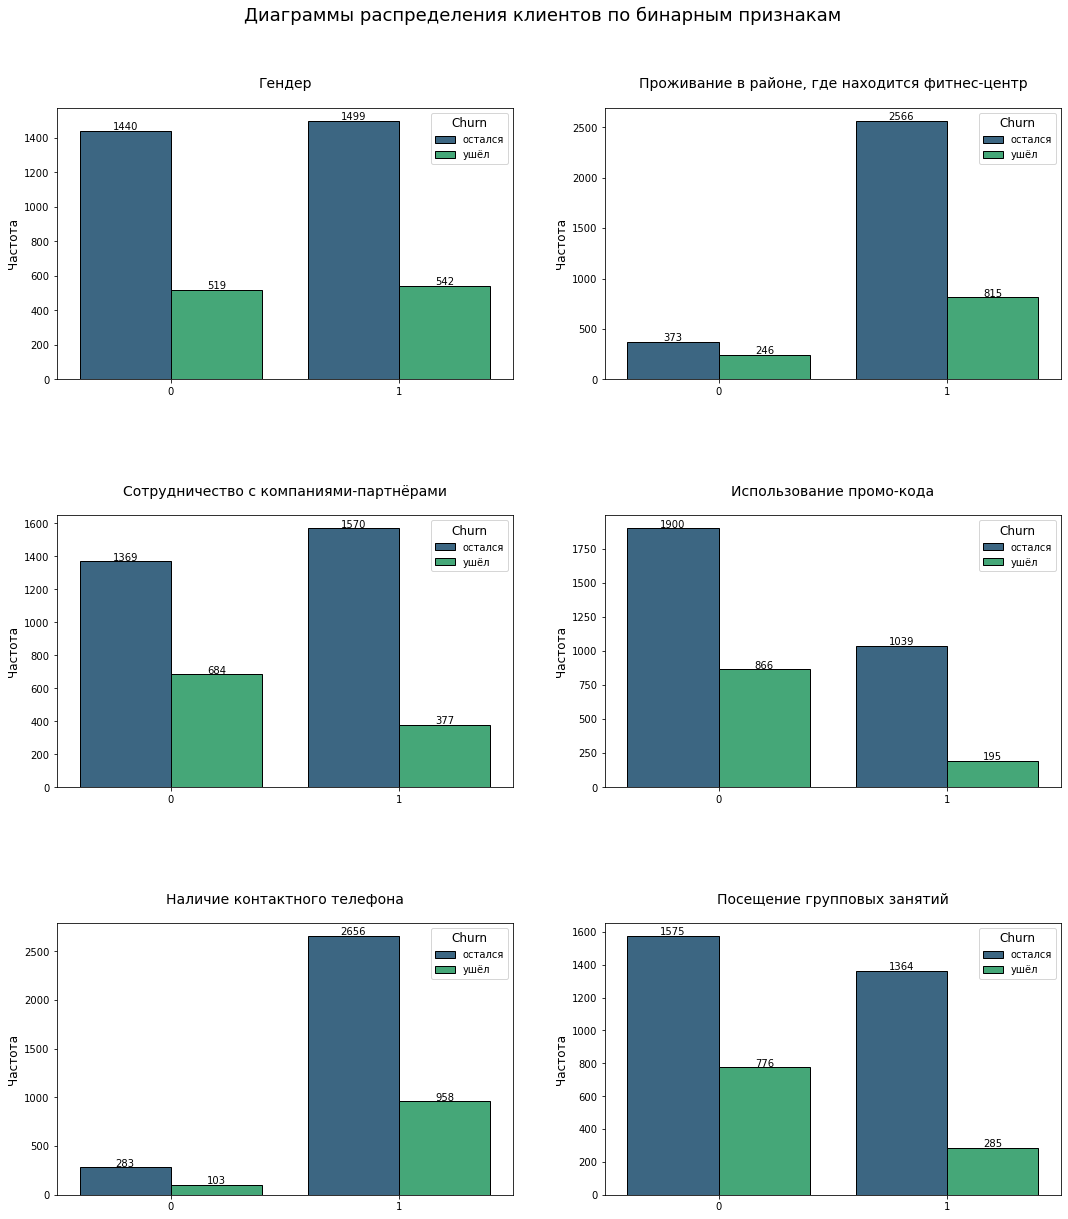

In [8]:
binary_distribution(df, ['Гендер', 'Проживание в районе, где находится фитнес-центр', 
                          'Сотрудничество с компаниями-партнёрами', 'Использование промо-кода', 
                          'Наличие контактного телефона', 'Посещение групповых занятий'], 
                   'Диаграммы распределения клиентов по бинарным признакам', 
                   'churn', 'Churn', ['остался', 'ушёл'])

Напишем функцию вывода гистограмм для непрерывных признаков.

In [9]:
def output_results(parameter, title, groupby_col, hue_param, legend_title, legend_labels, boxplot_x, boxplot_label):
    
    # вывод сводной таблицы
    average_data = round(df.groupby(groupby_col).
                        agg({parameter: [np.mean, np.median, np.var, np.std],
                            }), 2)
    
    display(average_data)
    
    # вывод графиков
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    
    sns.histplot(df, x=parameter, hue=hue_param, ax=axes[0], multiple="stack", palette='viridis')
    axes[0].set_title('Гистограмма', y=1.05, fontsize=16)
    axes[0].set_xlabel(title, fontsize=14)
    axes[0].set_ylabel('Частота', fontsize=14)
    axes[0].legend(title=legend_title, loc='upper right', labels=legend_labels)
    plt.setp(axes[0].get_legend().get_texts(), fontsize='14') 
    plt.setp(axes[0].get_legend().get_title(), fontsize='16')

    sns.boxplot(x=boxplot_x, y=parameter, data=df, ax=axes[1], palette='viridis')
    axes[1].set_title('Диаграмма размаха', y=1.05, fontsize=16)
    axes[1].set_xlabel(boxplot_label, fontsize=14)
    axes[1].set_ylabel(title, fontsize=14)
        
    fig.suptitle(title, y=1.08, fontsize=20)

    fig.subplots_adjust(wspace=0.2, hspace = 0.2)

    plt.show()

contract_period                    
                 mean median    var   std
churn                                    
0                5.75    6.0  22.25  4.72
1                1.73    1.0   4.55  2.13

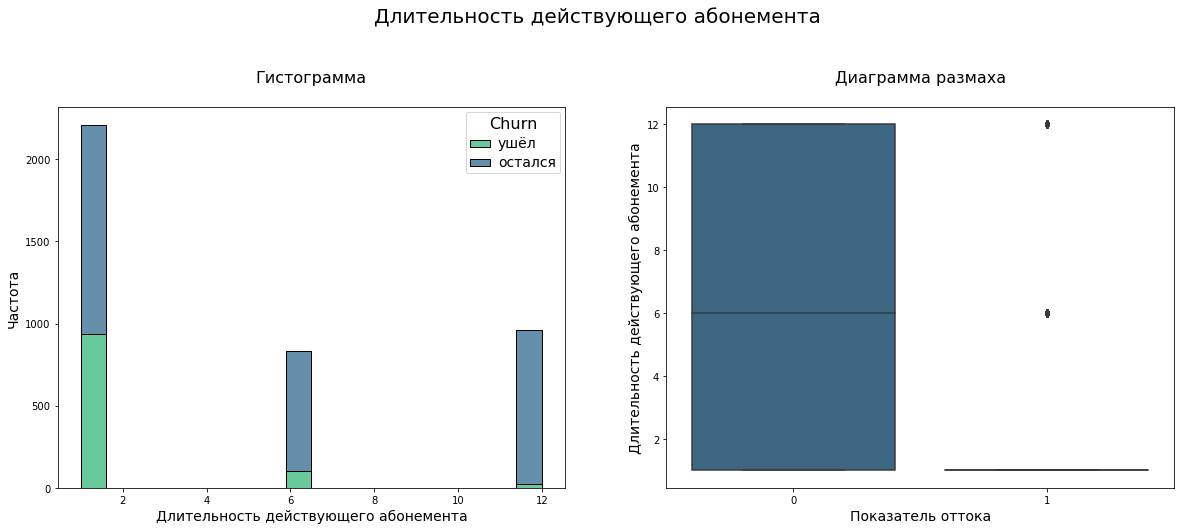

age                   
        mean median   var   std
churn                          
0      29.98   30.0  9.06  3.01
1      26.99   27.0  8.38  2.90

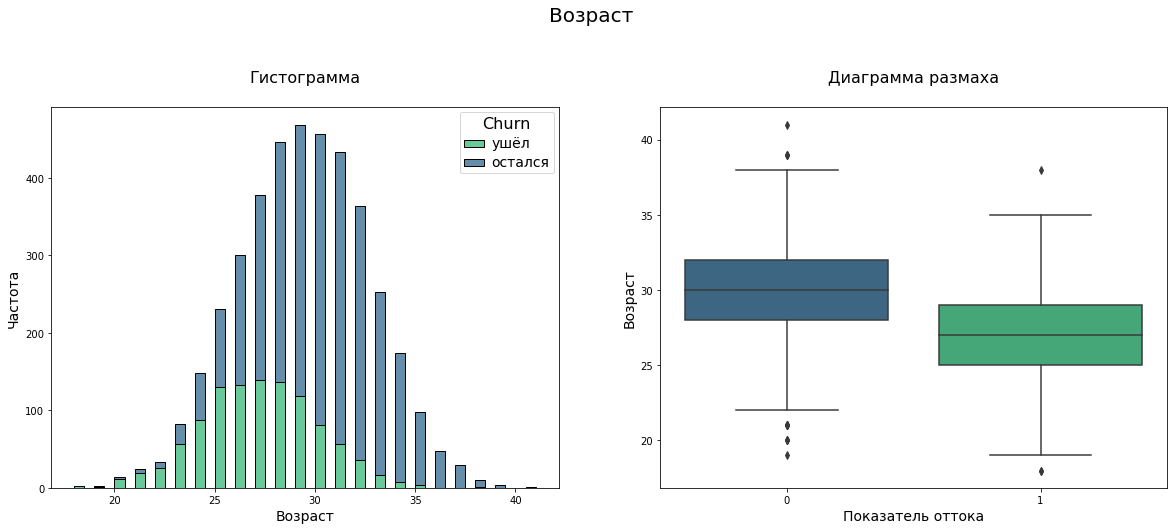

avg_additional_charges_total                       
                              mean  median      var   std
churn                                                    
0                           158.45  149.88  9960.36  99.8
1                           115.08  103.81  6036.73  77.7

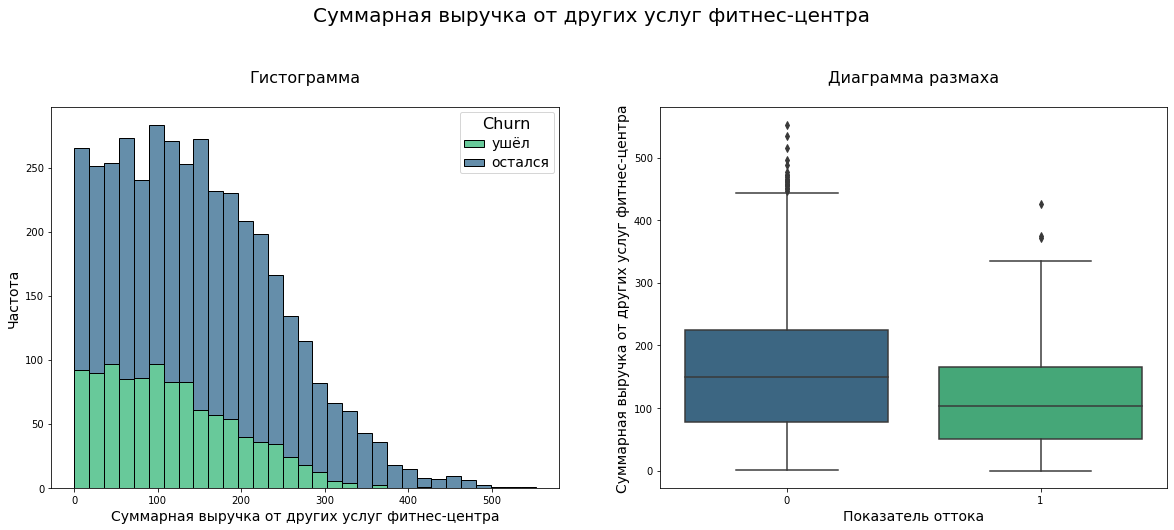

month_to_end_contract                    
                       mean median    var   std
churn                                          
0                      5.28    6.0  19.04  4.36
1                      1.66    1.0   3.86  1.96

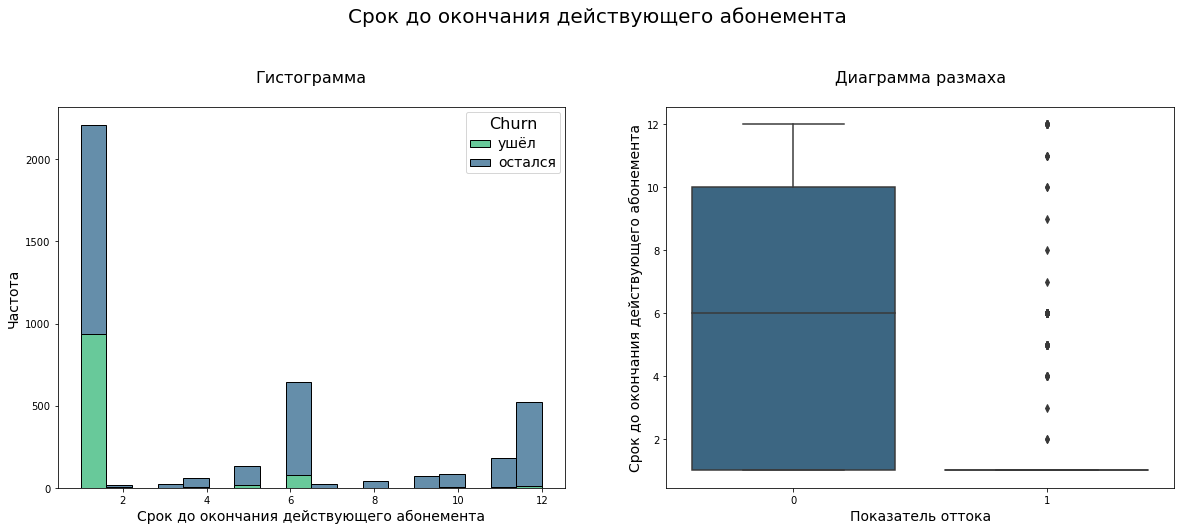

lifetime                    
          mean median    var   std
churn                             
0         4.71    4.0  15.01  3.87
1         0.99    1.0   1.23  1.11

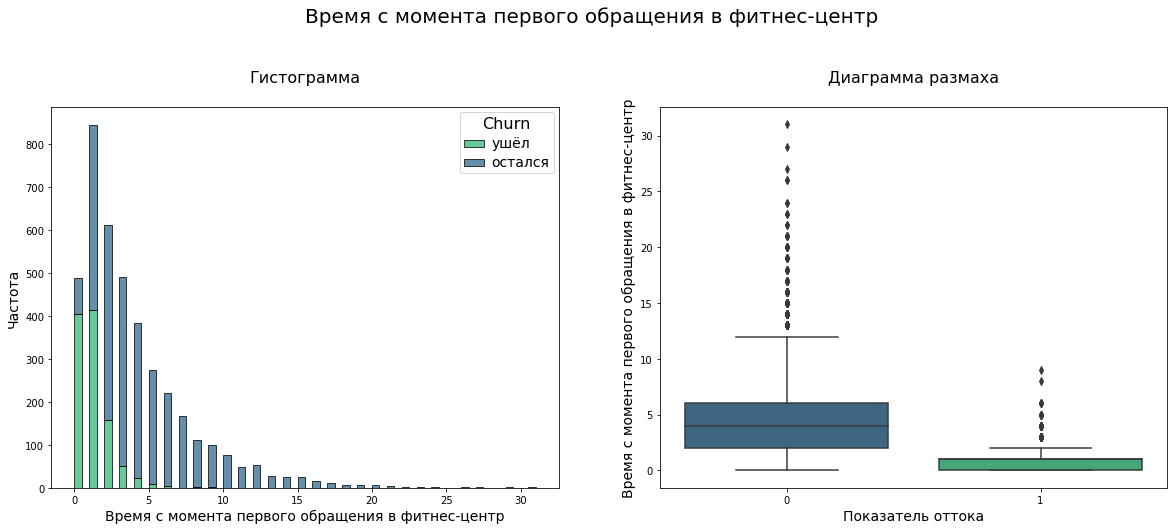

avg_class_frequency_total                   
                           mean median   var   std
churn                                             
0                          2.02   2.04  1.03  1.02
1                          1.47   1.49  0.48  0.69

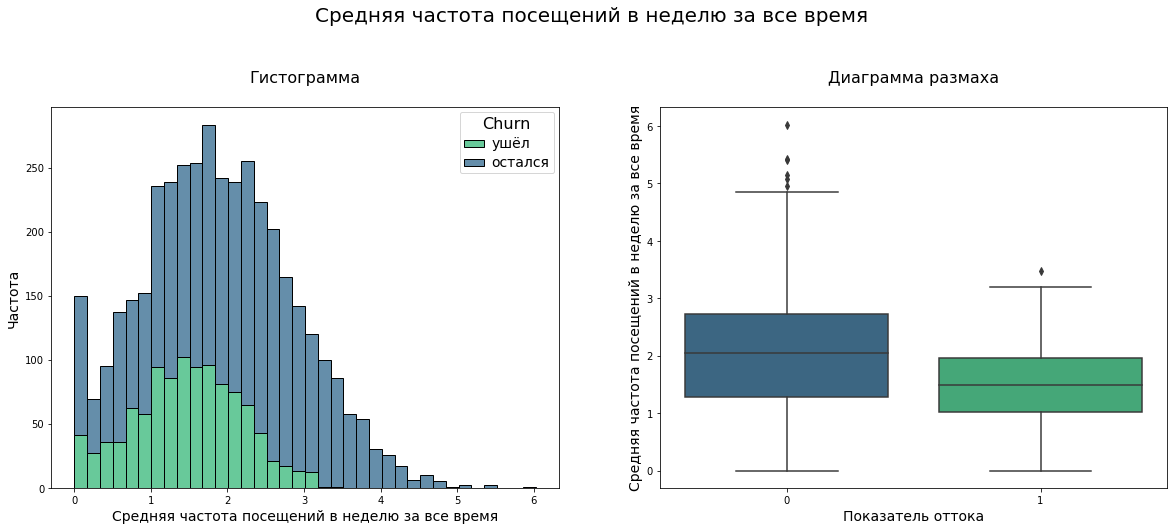

avg_class_frequency_current_month                   
                                   mean median   var   std
churn                                                     
0                                  2.03   2.05  1.04  1.02
1                                  1.04   0.98  0.59  0.77

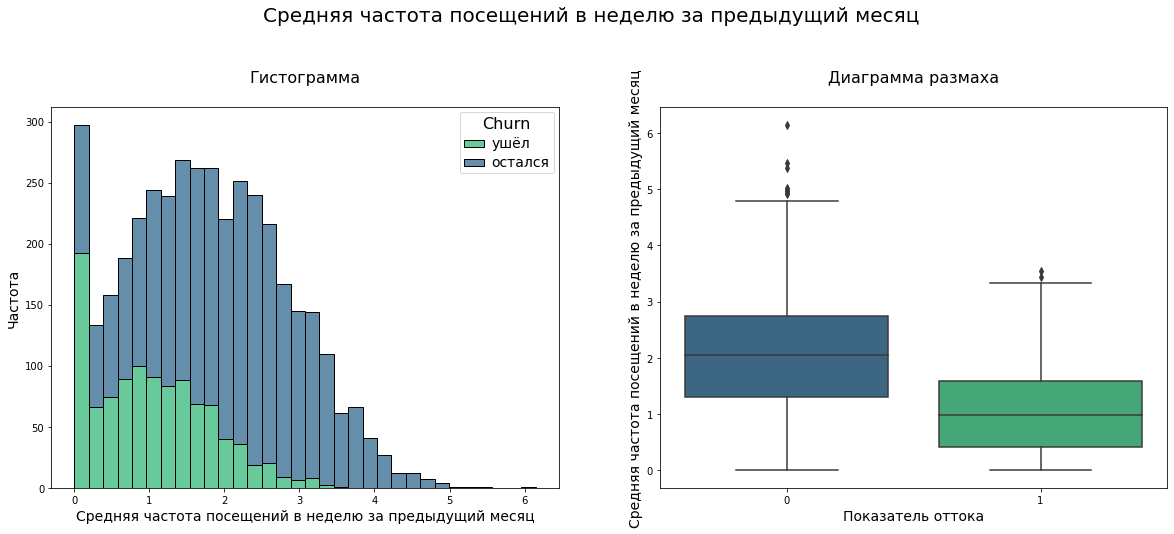

In [10]:
binary_features = [i for i in df.columns if len(df[i].value_counts())==2]
nonbinary_features = [x for x in df.columns if x not in binary_features]
parameters = nonbinary_features
suptitles = ['Длительность действующего абонемента', 'Возраст', 'Суммарная выручка от других услуг фитнес-центра',
            'Cрок до окончания действующего абонемента', 'Время с момента первого обращения в фитнес-центр', 
             'Cредняя частота посещений в неделю за все время', 'Средняя частота посещений в неделю за предыдущий месяц']
for i, value in enumerate(parameters):
    output_results(value, suptitles[i], 'churn', 'churn', 'Churn', ['ушёл', 'остался'], 'churn', 'Показатель оттока')

Итак, гендер клиента никак не связан с фактом оттока, как и указание телефона. Кажется, что чаще перестают пользоваться услугами фитнес-центра те, кто не является сотрудником компаний-партнёров клуба, а также те, кто не использовал промо-код от знакомого при оплате первого абонемента. Еще можно отметить, что более молодые клиенты реже становятся постоянными посетителями, и часто перестают посещать клуб вскоре после покупки краткосрочнго абонемента на месяц.

3. Построим матрицу корреляций

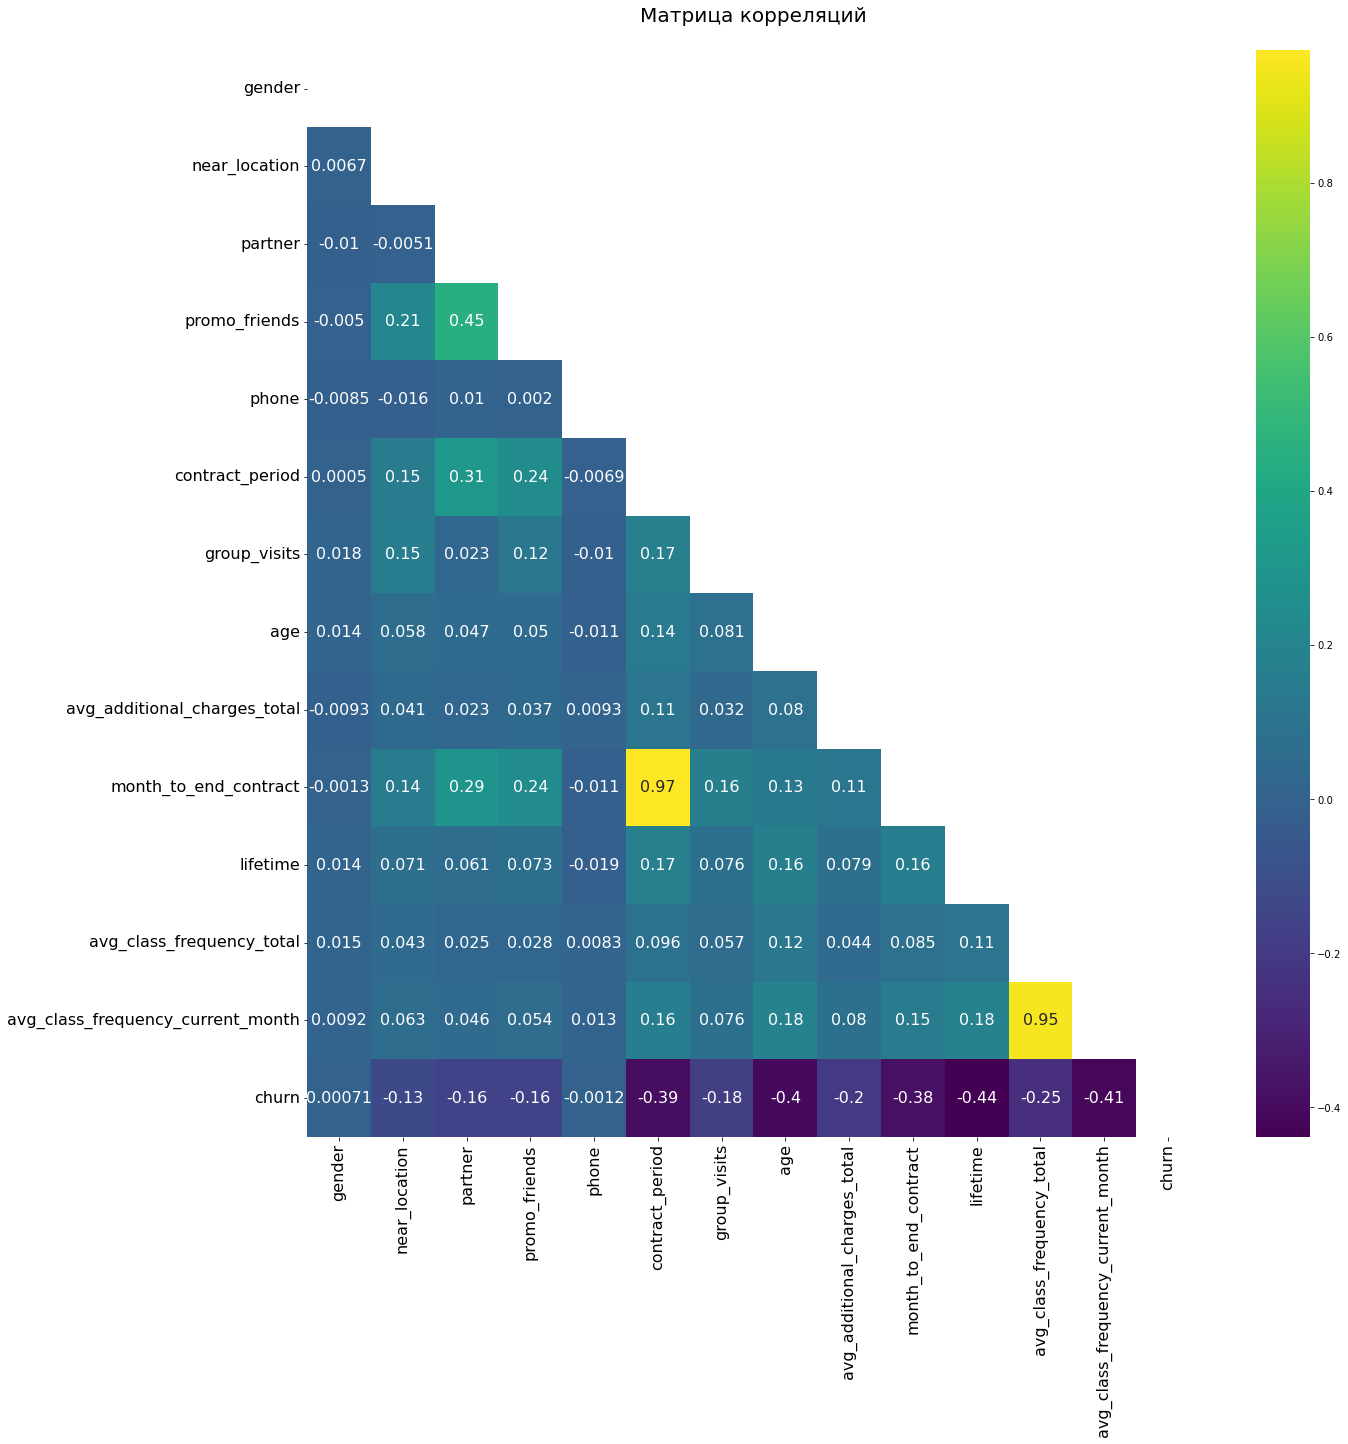

In [11]:
plt.figure(figsize=(20, 20)) 
mask = np.triu(np.ones_like(df.corr()))
ax = sns.heatmap(
     df.corr(),
     annot=True, 
     cmap="viridis",
     mask=mask, 
     annot_kws={"fontsize":16}
)

ax.set_title('Матрица корреляций', fontsize=20, y=1.02) 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

**Вывод**

Гендер (`gender`) и указание номера телефона (`phone`) никак не влияют на факт оттока. А такие признаки, как время использование фитнес-центра (`lifetime`), средняя частота посещений в неделю (`Avg_class_frequency_total`), возраст (`age`), длительность текущего действующего абонемента (`contract_period`), посещение групповых занятий (`group_visits`) сильно сказываются на том, продолжит ли клиент пользоваться услугами клуба.

Обнаружены мультиколлинеарные признаки - `contract_period` и `month_to_end_contract`, `avg_class_frequency_current_month` и `avg_class_frequency_total`. 

Избавимся от сильно скоррелированных признаков:

In [12]:
df.drop(['avg_class_frequency_total', 'month_to_end_contract'], axis=1, inplace=True)

## Прогнозирование оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.
Отметим, что классы несбалансированы: данные смещены в сторону тех, кто продолжает пользоваться услугами фитнес-центром.

In [13]:
df['churn'].value_counts(normalize=True)

0    0.73475
1    0.26525
Name: churn, dtype: float64

Напишем функцию визуализации метрик.

In [14]:
def print_metrics(y_test, predictions, probabilities, title):
    
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, predictions)
    cf_matrix = confusion_matrix(y_test, predictions)

    fig, axes = plt.subplots(2,2, figsize=(20, 10), gridspec_kw={'height_ratios': [1, 0.04]})
    
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    heatmap = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='viridis', annot_kws={"size": 20}, ax=axes[0][0])
    axes[0][0].xaxis.set_visible(False)
    axes[0][0].yaxis.set_visible(False)

    axes[0][0].set_title('Confusion Matrix', fontsize=20, pad=20)

    df = pd.DataFrame([round(i,3) for i in [accuracy, precision, recall, f1, roc_auc]],
                      ['accuracy_score', 'precision_score', 'recall_score', 'f1_score', 'roc_auc_score'])

    
    axes[1][0].axis('tight')
    axes[1][0].axis('off')
    table = axes[1][0].table(cellText=df.values, rowLabels=df.index, 
                          cellLoc='center', loc='top', colWidths=[0.2,0.2], **{"fontsize": 8})
    table.scale(2, 2)
    table.set_fontsize(18)

    fig.tight_layout()
    plt.subplots_adjust(hspace=0.7)
    
    
    log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test, probabilities)
    axes[0][1].plot(log_reg_fpr, log_reg_tpr, label=title + ' prediction (AUROC = %0.3f)' % roc_auc, linewidth=3)
    axes[0][1].set_title('ROC Plot', fontsize=20, pad=20)
    axes[0][1].set_xlabel('False Positive Rate', fontsize=16)
    axes[0][1].set_ylabel('True Positive Rate', fontsize=16) 
    axes[0][1].tick_params(axis='both', labelsize=14)
    
    r_probs = [0 for _ in range(len(y_test))]
    r_auc = roc_auc_score(y_test, r_probs)
    r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
    axes[0][1].plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc, linewidth=3)
    axes[0][1].legend(fontsize = 16)
    
    axes[1][1].axis('off')

    plt.show()

### Логистическая регрессия

#### Логистическая регрессия без балансировки классов

In [15]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(columns=['churn'])
y = df['churn']

# разделим модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

# зададим алгоритм для модели
lr_model = LogisticRegression(penalty='l2', random_state=0) 

# обучим модель
lr_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

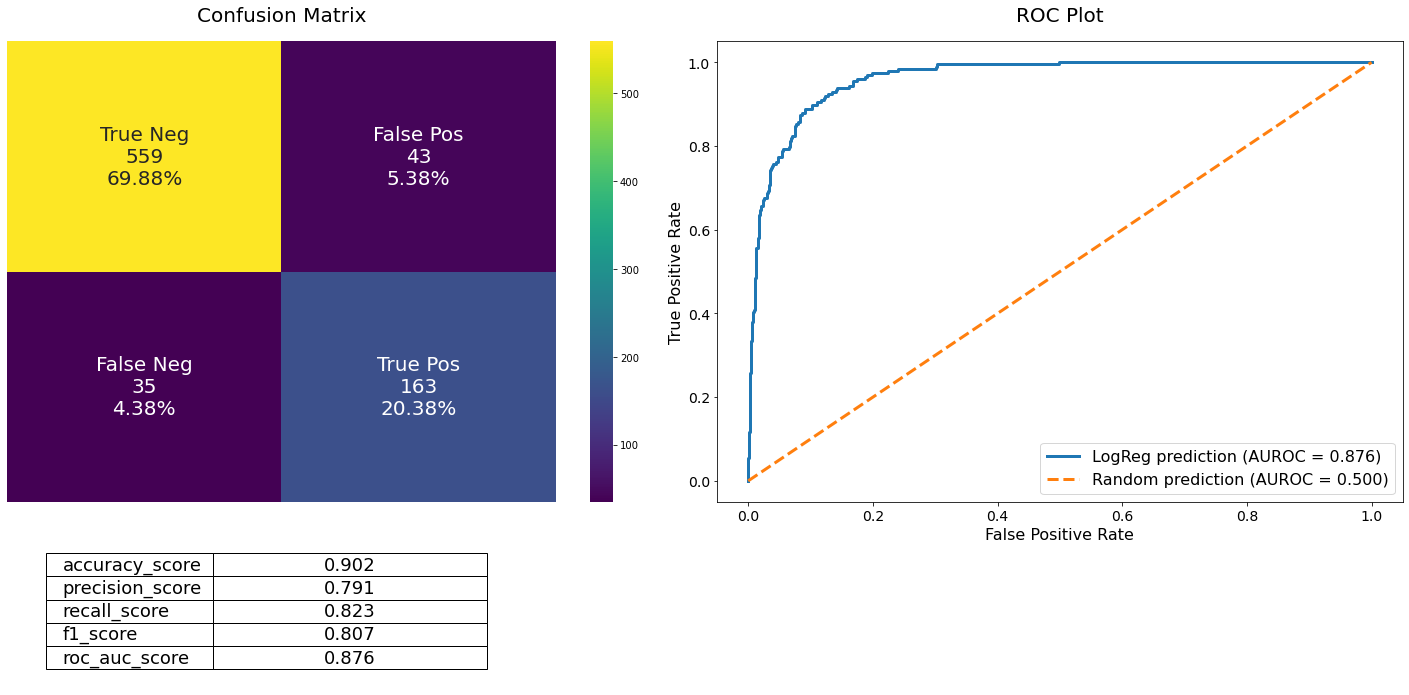

In [16]:
print_metrics(y_test, lr_predictions, lr_probabilities, 'LogReg')

#### Логистическая регрессия c балансировкой классов

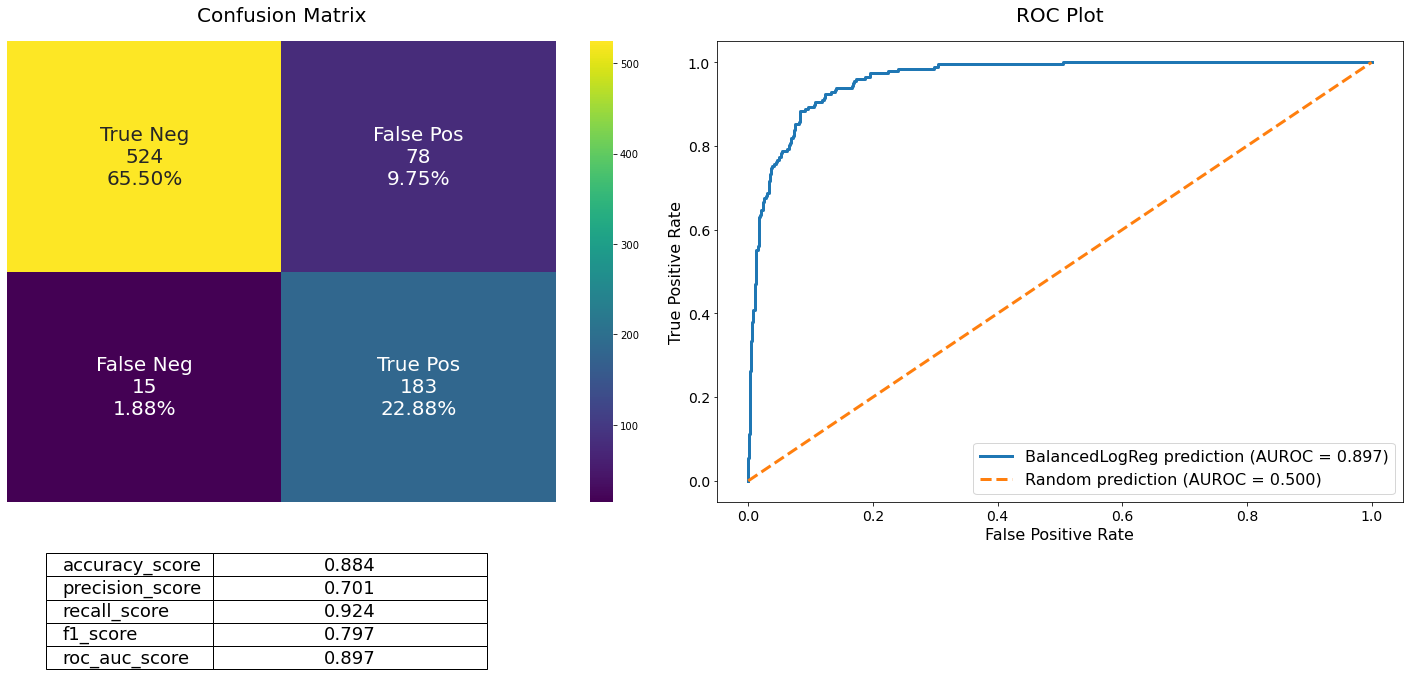

In [17]:
# зададим алгоритм для модели
lr_balanced_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=0, class_weight='balanced') 

# обучим модель
lr_balanced_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_balanced_predictions = lr_balanced_model.predict(X_test_st)
lr_balanced_probabilities = lr_balanced_model.predict_proba(X_test_st)[:,1]

print_metrics(y_test, lr_balanced_predictions, lr_balanced_probabilities, 'BalancedLogReg')

Видим, что некоторые метрики (acuracy, precision, f1) упали. Однако, модель с балансировкой чаще обнаруживает ушедших клиентов. Понимание того, кто из пользователей намерен вскоре перестать пользоваться услугами фитнес-центра, позволит направить усилия на их удержание.

### Cлучайный лес

#### RandomForest

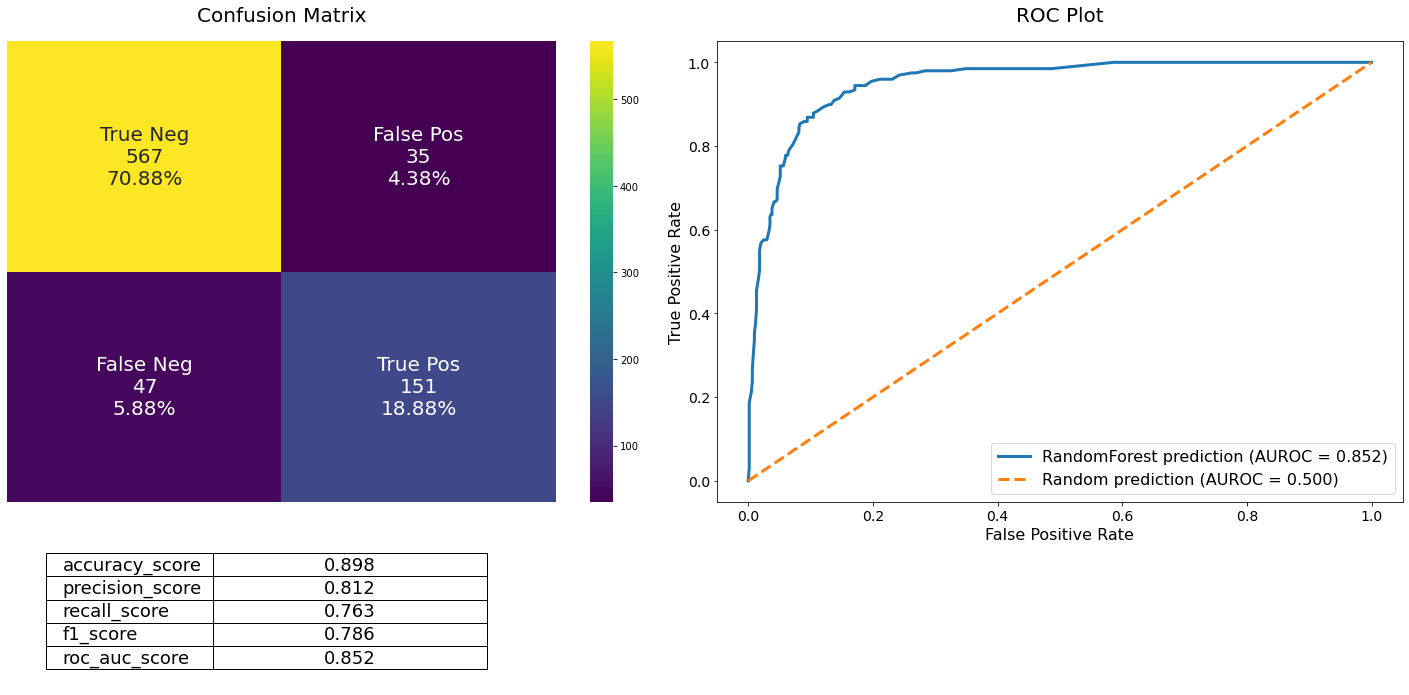

In [18]:
# зададим алгоритм для модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight='balanced_subsample')
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]

print_metrics(y_test, rf_predictions, rf_probabilities, 'RandomForest')

#### RandomForest с настройкой гиперпараметров

In [19]:
# GridSearch
parameters = {
    "n_estimators":[5,10,50,100],
    "max_depth":[2,4,8,16,32]  
}
cv = GridSearchCV(RandomForestClassifier(class_weight='balanced_subsample'), 
                  param_grid=parameters, 
                  scoring='f1', 
                  cv=3, 
                  n_jobs=-1)
cv.fit(X_train_st, y_train.values.ravel());

In [20]:
pd.DataFrame(cv.cv_results_).drop('params', axis=1).sort_values(by='rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
11,0.384908,0.003182,0.026263,0.000470,8,100,0.846024,0.824503,0.820946,0.830491,0.011079,1
9,0.049203,0.004483,0.005650,0.000474,8,10,0.833333,0.822951,0.825503,0.827263,0.004417,2
10,0.201128,0.004976,0.013963,0.000000,8,50,0.840480,0.821963,0.816949,0.826464,0.010120,3


In [21]:
print('Лучшие параметры: {}'.format(cv.best_params_))

Лучшие параметры: {'max_depth': 8, 'n_estimators': 100}


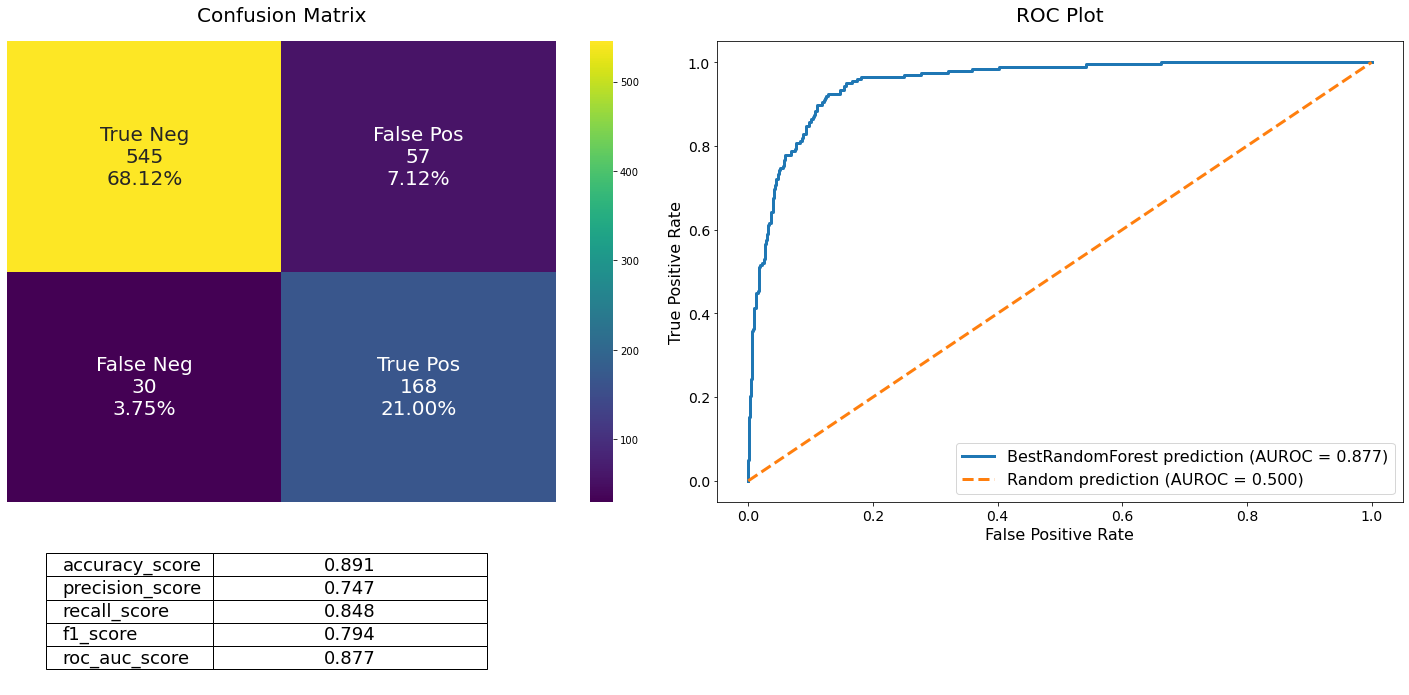

In [22]:
rf_best_model = cv.best_estimator_
rf_best_model.fit(X_train_st, y_train);
rf_best_predictions = rf_best_model.predict(X_test_st)
rf_best_probabilities = rf_best_model.predict_proba(X_test_st)[:, 1]
print_metrics(y_test, rf_best_predictions, rf_best_probabilities, 'BestRandomForest')

**Вывод**

Модель случайного леса с настройкой гиперпараметров показала результаты лучше, чем модель с гиперпараметрами по умолчанию. Однако, RandomForestClassifier реже обычной логистической регрессии с балансировкой классов обнаруживает ушедших в отток клиентов, а, как было отмечено ранее, для бизнеса важно понимать, кто из пользователей, уйдет в отток.

Для решения поставленной задачи - прогнозирование оттока клиентов, лучше всего показала себя модель логистической регрессии с балансировкой классов. Выделим значимые признаки для этой модели.

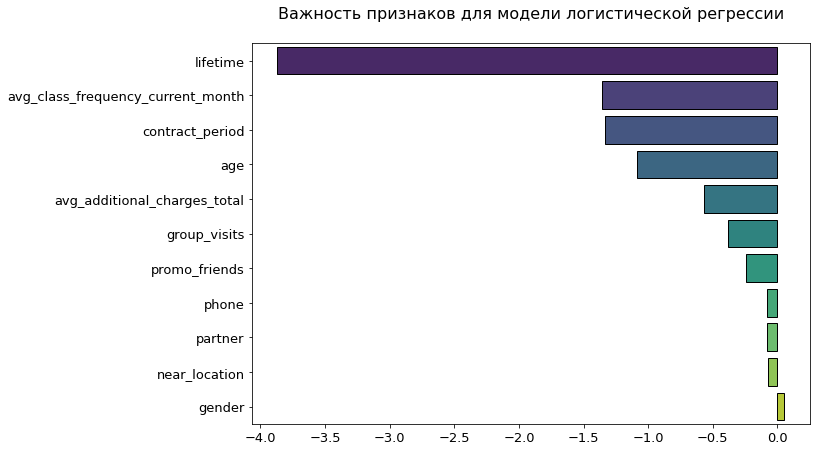

In [23]:
featuer_imp = (pd.Series(lr_balanced_model.coef_[0], index=X.columns)).sort_values().to_frame()

plt.figure(figsize=(10, 7))

plot_feature = sns.barplot(y=featuer_imp.index, x=featuer_imp[0], palette='viridis', edgecolor='black')
plot_feature.set_title('Важность признаков для модели логистической регрессии', y=1.05, fontsize=16)
plot_feature.set_xlabel("")
plot_feature.tick_params(axis='both', labelsize=13)
plt.show()

Отметим наиболее важные признаки (feature importance) в модели:
- `lifetime` - время с момента первого обращения в фитнес-центр;
- `contract_period` - длительность текущего действующего абонемента;
- `age` - возраст.

## Кластеризация клиентов

Сформируем типичные портреты клиентов: выделим несколько наиболее ярких групп и охарактеризуем их основные свойства.

1. Визуализируем дендрограмму и выделим основное количество кластеров.

In [24]:
# cтандартизируем данные
scaler = StandardScaler() # создаём объект класса scaler 
x_sc = scaler.fit_transform(df.drop(columns = ['churn'])) # обучаем нормализатор и преобразуем набор данных 

# построим матрицу расстояний функцией на стандартизованной матрице признаков
linked = linkage(x_sc, method = 'ward') 

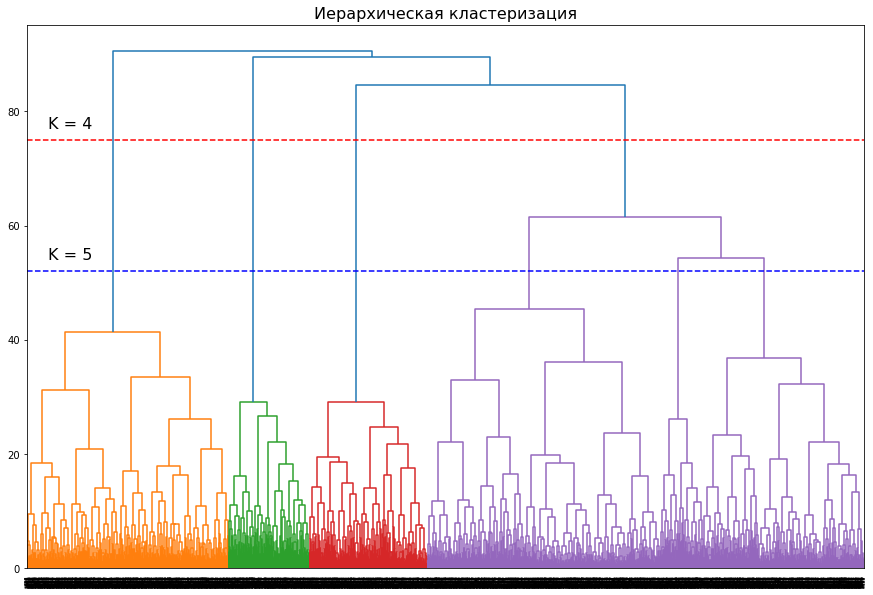

In [25]:
# визуализируем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация', fontsize=16)
plt.axhline(y=75, color='r', linestyle='--', )
plt.axhline(y=52, color='b', linestyle='--', )
plt.text(1000, 77, 'K = 4', fontsize = 16)
plt.text(1000, 54, 'K = 5', fontsize = 16)
plt.show() 

Предложенное оптимальное число кластеров равно 5.

2. Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

In [26]:
# задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата
km = KMeans(n_clusters=5, random_state=0)
# применяем алгоритм к данным и формируем вектор кластеров 
labels = km.fit_predict(x_sc) 

# сохраняем метки кластера в поле нашего датасета
df['cluster_client'] = labels

3. Выведем статистику по средним значениям наших признаков по кластеру

In [27]:
(
    df.groupby('cluster_client')
    .agg({**{x:'mean' for x in df.columns}, 'cluster_client': 'count'})
    .rename(columns={'cluster_client': 'cluster_size'})
    .T
)

cluster_client,0,1,2,3,4
gender,0.496447,0.500000,0.500940,0.534260,0.523316
near_location,0.995939,0.000000,1.000000,0.996028,0.862694
partner,0.892386,0.489247,0.217105,0.379345,0.471503
promo_friends,1.000000,0.078853,0.072368,0.009930,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,6.922843,2.994624,2.010338,6.208540,4.777202
group_visits,0.524873,0.232975,0.277256,0.538232,0.427461
age,29.606091,28.679211,27.583647,30.699106,29.297927
avg_additional_charges_total,153.424651,137.125763,119.339956,176.259567,144.208179
lifetime,4.283249,2.974910,1.922932,5.415094,3.940415


4. Построим столбчатые гистограммы и распределения признаков для выделенных кластеров.

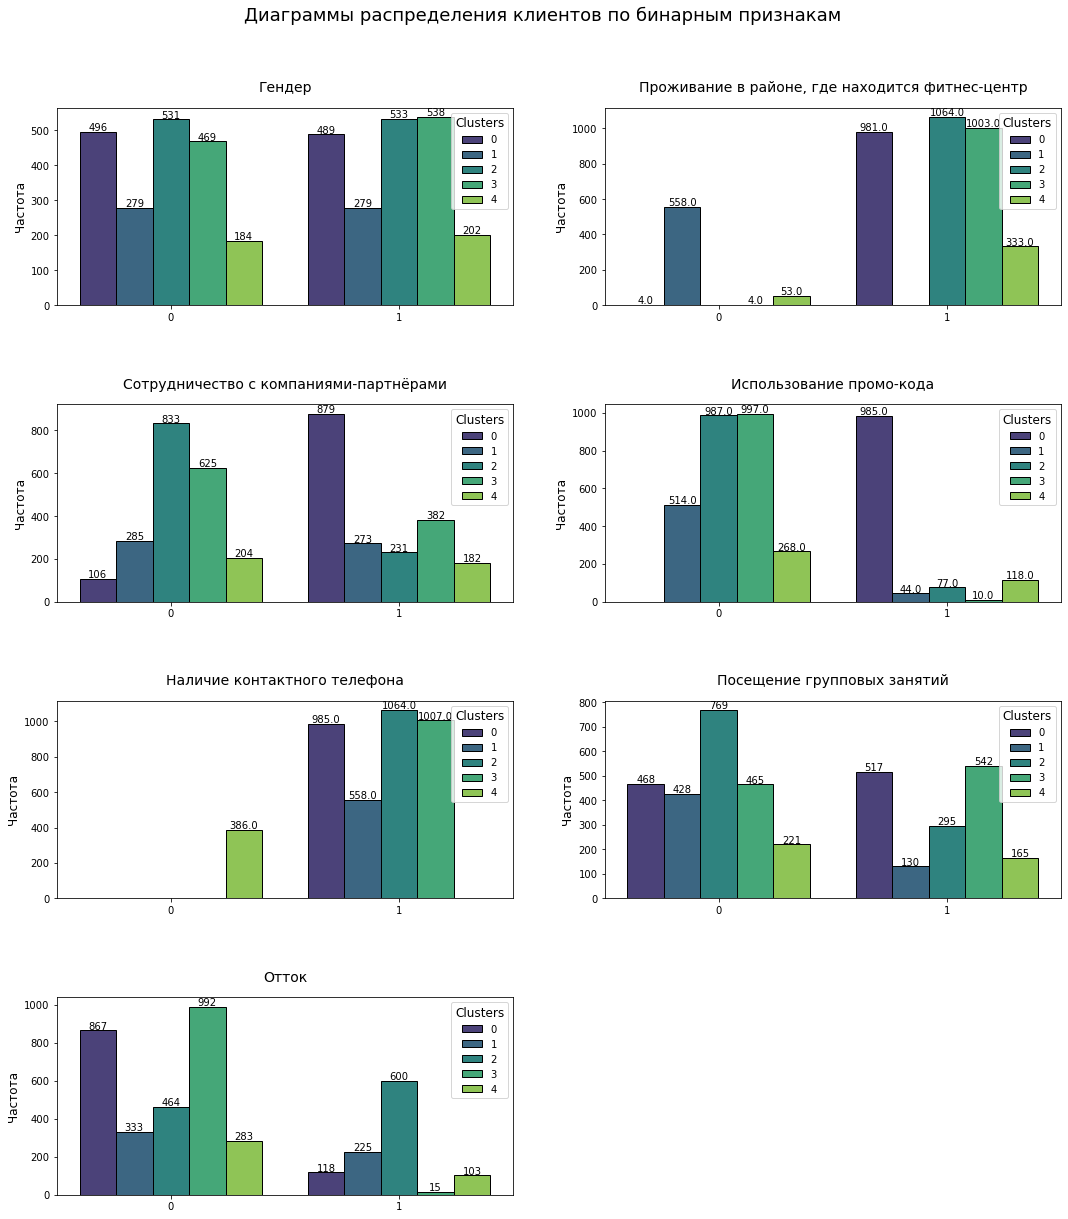

In [28]:
binary_distribution(df, ['Гендер', 'Проживание в районе, где находится фитнес-центр', 
          'Сотрудничество с компаниями-партнёрами', 'Использование промо-кода', 
          'Наличие контактного телефона', 'Посещение групповых занятий', 'Отток'], 
                    "Диаграммы распределения клиентов по бинарным признакам", 
                    'cluster_client', 'Clusters', [0, 1, 2, 3, 4, 5], remove=False)

contract_period                    
                          mean median    var   std
cluster_client                                    
0                         6.92    6.0  22.30  4.72
1                         2.99    1.0  12.29  3.51
2                         2.01    1.0   6.21  2.49
3                         6.21    6.0  22.86  4.78
4                         4.78    1.0  20.57  4.54

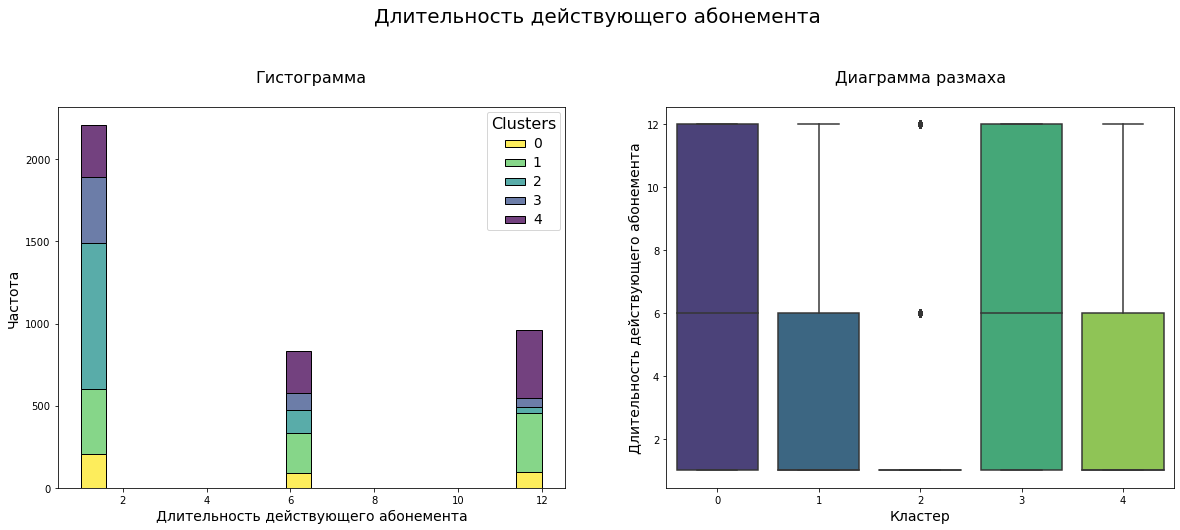

age                    
                 mean median    var   std
cluster_client                           
0               29.61   30.0   9.60  3.10
1               28.68   29.0  10.30  3.21
2               27.58   28.0   8.73  2.95
3               30.70   31.0   8.74  2.96
4               29.30   29.0   9.99  3.16

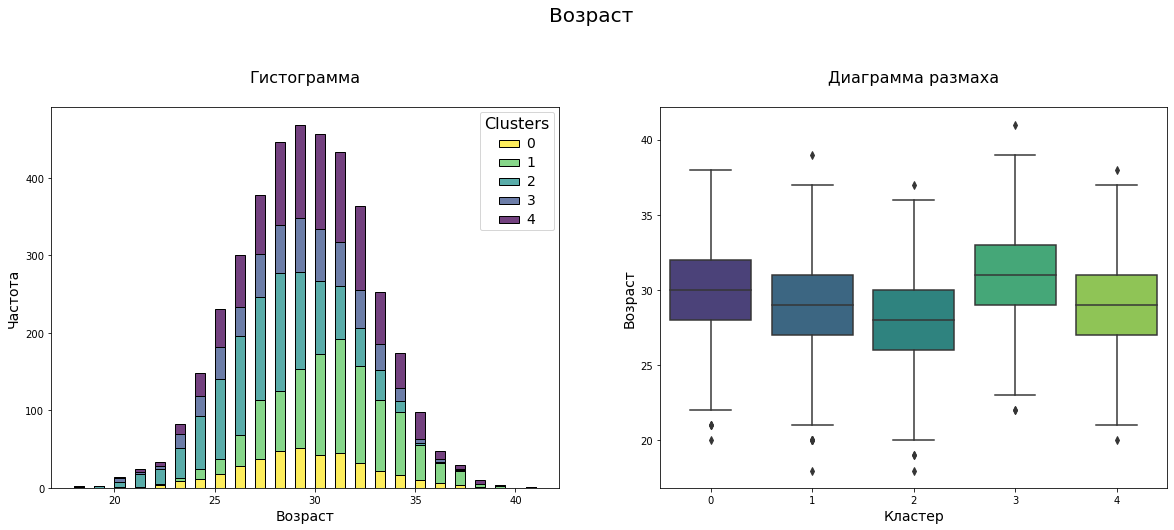

avg_additional_charges_total                          
                                       mean  median       var     std
cluster_client                                                       
0                                    153.42  148.05   9238.22   96.12
1                                    137.13  124.21   9194.00   95.89
2                                    119.34  106.90   6823.63   82.61
3                                    176.26  169.25  10415.74  102.06
4                                    144.21  137.02   8859.47   94.12

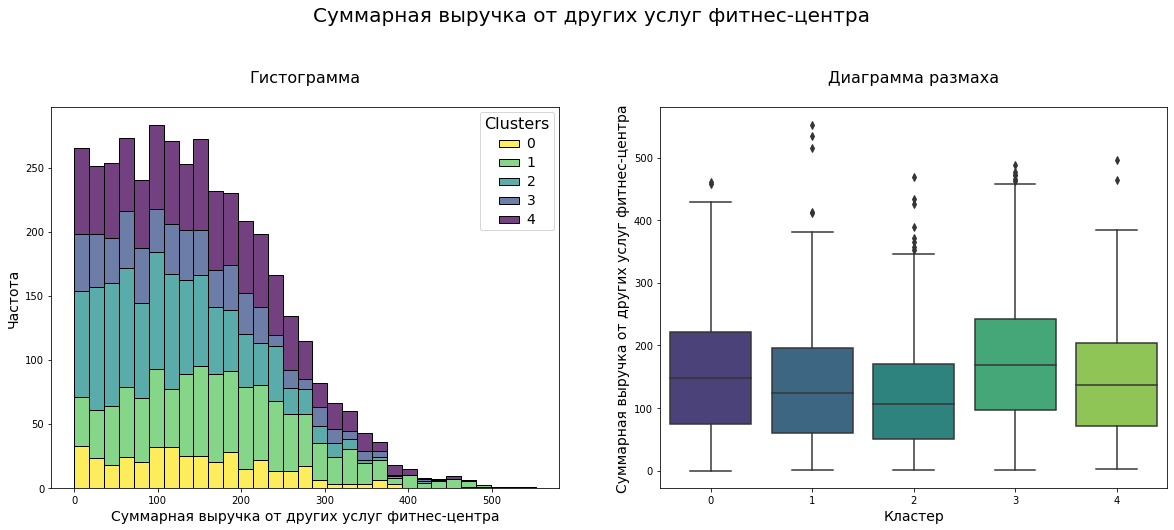

lifetime                    
                   mean median    var   std
cluster_client                             
0                  4.28    3.0  13.62  3.69
1                  2.97    2.0  10.10  3.18
2                  1.92    1.0   4.25  2.06
3                  5.42    4.0  19.25  4.39
4                  3.94    3.0  16.43  4.05

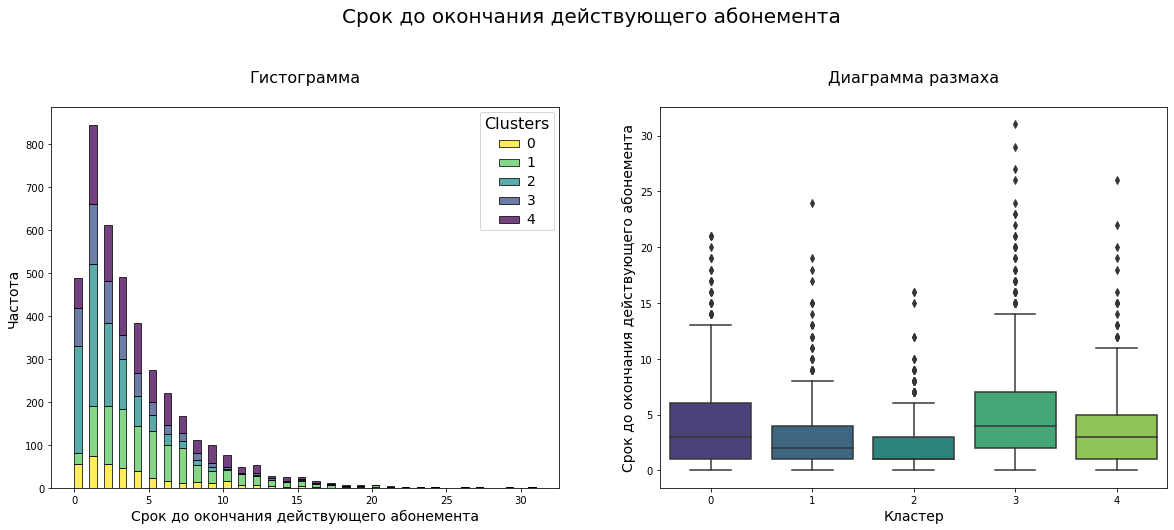

avg_class_frequency_current_month                   
                                            mean median   var   std
cluster_client                                                     
0                                           1.92   1.90  1.08  1.04
1                                           1.60   1.50  1.06  1.03
2                                           1.20   1.14  0.71  0.84
3                                           2.32   2.38  0.93  0.96
4                                           1.72   1.66  1.05  1.02

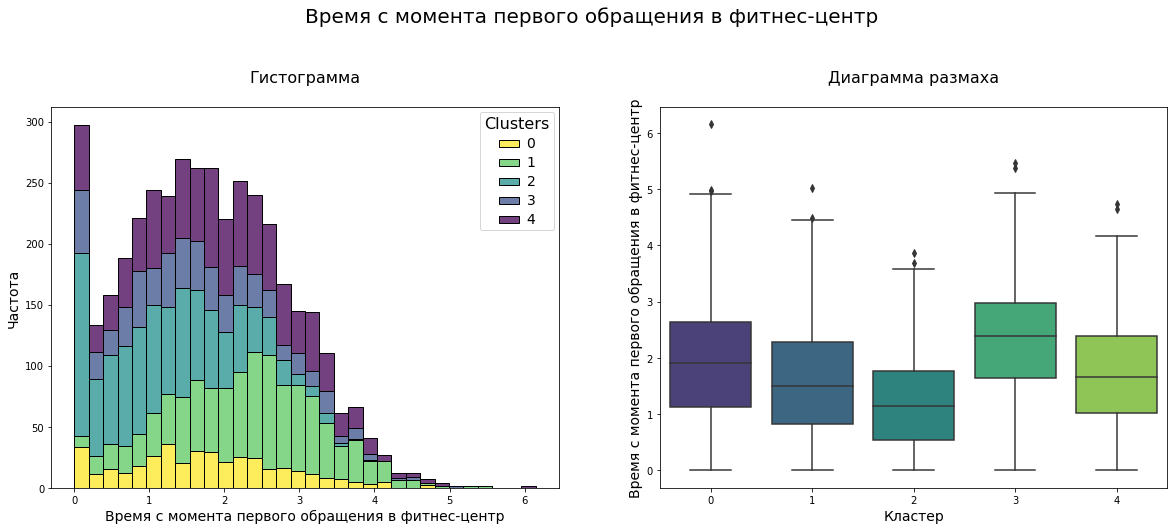

In [29]:
column_list = df.columns.to_list()
column_list.remove('churn')
nonbinary_features = [x for x in column_list if x not in binary_features]
nonbinary_features.remove('cluster_client')
parameters = nonbinary_features
suptitles = ['Длительность действующего абонемента', 'Возраст', 'Суммарная выручка от других услуг фитнес-центра',
            'Cрок до окончания действующего абонемента', 'Время с момента первого обращения в фитнес-центр', 
             'Cредняя частота посещений в неделю за все время', 'Средняя частота посещений в неделю за предыдущий месяц']
for i, value in enumerate(parameters):
    output_results(value, suptitles[i], 'cluster_client', 'cluster_client', 'Clusters', [0, 1, 2, 3, 4], 'cluster_client', 'Кластер')

4. Для каждого полученного кластера посчитаем долю оттока 

In [30]:
df.groupby('cluster_client')['churn'].mean().to_frame()

,churn
cluster_client,
0,0.119797
1,0.403226
2,0.563910
3,0.014896
4,0.266839


**Вывод**

По многочиленности кластеры распределились следующим образом:
- 2-ой класс - 1132 человека;
- 1-ый класс - 1050 человек;
- 3-ий класс - 871 человек;
- 0-ой класс - 561 человек.
- 4-ый класс - 386 человек.

В целом кластеры схожи по гендерному и возрастному признакам. Основные отличия наблюдаются в территориальной близости клуба к месту жительства или работы клиента. Также кластеры сильно различаются по каналу привлечения (фитнес в составе корпоративного пакета или рекомендация друга) и отношения к групповым тренировкам.

По доле оттока лидирует 0-ой класс: 40% клиентов, вероятно, вскоре перестанут пользоваться услугами фитнес-центра. Затем следует 2-ой класс (38% клиентов не продлят абонемент). Самым высоким уровнем лояльности отличается класс 1: 88% посетителей устраивает уровень сервиса. Также клиенты из этого кластера заключают более долгосрочные соглашения с фитнес-клубом и дольше не прекращают занятий.



## Общий вывод и рекомендации

1. Была построена модель прогнозирования оттока пользователей фитнес-центра: лучше всего показала себя модель логистической регрессии с балансировкой классов. Она помогает чаще обнаруживать клиентов, намеренных перестать пользоваться услугами клуба.


2. Был получен типичный портрет лояльного клиента фитнес-клуба:
    - человек в возрасте 30 лет;
    - проживающий или работающий в районе расположения фитнес-центра;
    - являющийся сотрудником компании-партнера или пришедший по рекомендации друзей;
    - заключающий долгосрочные соглашения с фитнес-клубом;
    - регулярно посещающий занятия.


3. Модель прогнозирования оттока позволяет выявлять сомневающихся клиентов. Поскольку лучший способ избежать оттока – это предотвратить его, теперь есть возможность обратиться к таким клиентам вовремя и направить усилия на их удержание: например, предлагать скидки и специальные предложения. 

4. Еще один эффективный подход к уменьшению оттока пользоватеелй - предложение долгосрочных контрактов вместо ежемесячных. 